In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime, date
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from sklearn.metrics import r2_score

import mlflow

mlflow.autolog()

2026-01-12 05:37:30.730168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-12 05:37:30.755565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-12 05:37:30.763324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-12 05:37:32.807389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/coder/miniconda3/envs/mlflow-fd36bac35c4ea7229080774d8c3871a103b15657/lib/python3.9/site-packages/google/auth/__init__.py:54: FutureWarning: 
    You are using a Python version 3.9 past its end of life. Google will update
    google-au

In [2]:
# read data
data = pd.read_csv('~/minio-data/jrfm-2156907-cleaned.csv')
data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,Active Addr Cnt,Xfer Cnt,Mean Tx Size (native units),Total Fees (USD),...,RUB,Tweets,Google,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2015-08-07,278.740997,280.391998,276.365997,279.584991,42484800.0,283150,497302,2.057514,7235.134845,...,64.480003,47467,90.000000,0,0,0,0,1,0,0
1,2015-08-08,279.742004,279.928009,260.709991,260.997009,58533000.0,266587,284532,3.675623,5806.842316,...,64.480003,29031,91.578947,0,0,0,0,0,1,0
2,2015-08-09,261.115997,267.002991,260.467987,265.083008,23789600.0,262571,276720,4.201519,4952.554125,...,64.480003,27132,91.578947,0,0,0,0,0,0,1
3,2015-08-10,265.477997,267.032013,262.596008,264.470001,20979400.0,292834,304538,3.463212,7563.840456,...,64.480003,27744,96.315789,1,0,0,0,0,0,0
4,2015-08-11,264.342010,270.385986,264.093994,270.385986,25433900.0,271613,280398,3.785274,7128.842169,...,62.889999,26653,104.210526,0,1,0,0,0,0,0


In [3]:
data.shape

(2430, 48)

In [4]:
data["Date"] = pd.to_datetime(data["Date"])

In [5]:
# Split data into 2 periods
start_day_p1 = pd.Timestamp(2015, 8, 7)
test_day_p1 = pd.Timestamp(2018, 4, 1)
end_day_p1 = pd.Timestamp(2018, 9, 30)

period1 = data[(data["Date"] >= start_day_p1) & (data["Date"] <= end_day_p1) ].reset_index(drop = True)
train_dataset_p1 = period1[period1["Date"] < test_day_p1].reset_index(drop = True)
test_dataset_p1 = period1[period1["Date"] >= test_day_p1].reset_index(drop = True)


start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] >= start_day_p2) & (data["Date"] <= end_day_p2) ].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)

train_dataset_p1 = train_dataset_p1.drop("Date", axis=1)
test_dataset_p1 = test_dataset_p1.drop("Date", axis=1)
train_dataset_p2 = train_dataset_p2.drop("Date", axis=1)
test_dataset_p2 = test_dataset_p2.drop("Date", axis=1)


print(period1.shape, period2.shape)

(1151, 48) (1279, 48)


In [6]:
# Metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100
# Scaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor


def create_data_RF(train_dataset, test_dataset):
	X_train = train_dataset[:-1]
	Y_train = train_dataset["BTC_Close"][1:]
	X_test = test_dataset[:-1]
	Y_test = test_dataset["BTC_Close"][1:]
	return X_train, Y_train, X_test, Y_test


def train_model_RF(X_train, Y_train, X_test):
	rfr = RandomForestRegressor(max_depth=10, n_estimators=500)
	rfr.fit(X_train, Y_train)
	pred_y = rfr.predict(X_test)
	return pred_y

# LSTM
def create_data_LSTM(train_dataset, test_dataset, scaled=True, time_step=1):
	def create_sequences(data, target, time_step):
		X, y = [], []
		for i in range(len(data) - time_step):
			X.append(data[i:(i + time_step)])
			y.append(target[i + time_step])
		return np.array(X), np.array(y)

	X_train = train_dataset
	Y_train = train_dataset["BTC_Close"]
	X_test = test_dataset
	Y_test = test_dataset["BTC_Close"]
	X_train, Y_train = create_sequences(X_train, Y_train, time_step=time_step)
	X_test, Y_test = create_sequences(X_test, Y_test, time_step=time_step)
	if (scaled == True):
		scaler = MinMaxScaler()
		X_train_scaled = scaler.fit_transform(
			X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
		X_test_scaled = scaler.transform(
			X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
		X_train = X_train_scaled
		X_test = X_test_scaled

	return X_train, Y_train, X_test, Y_test

from tensorflow.keras.callbacks import EarlyStopping # type: ignore
def train_model_lstm(X_train, Y_train, X_test, epochs=30):
	model = tf.keras.Sequential([
		tf.keras.layers.LSTM(128, activation='relu', input_shape=(
			X_train.shape[1], X_train.shape[2]), return_sequences=True),
		tf.keras.layers.Dropout(0.2),
		tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
		tf.keras.layers.Dropout(0.3),
		tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
		tf.keras.layers.Dropout(0.4),
		tf.keras.layers.LSTM(256, activation='relu', return_sequences=False),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(1)
	])
	model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
	early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
	history = model.fit(X_train, Y_train, epochs=epochs)
	prediction = model.predict(X_test)
	return prediction

In [8]:
# Create data
## Random Forest
X_train_RF_p1, Y_train_RF_p1, X_test_RF_p1, Y_test_RF_p1 = create_data_RF(train_dataset_p1, test_dataset_p1)
## LSTM
X_train_LSTM_l1_p1, Y_train_LSTM_l1_p1, X_test_LSTM_l1_p1, Y_test_LSTM_l1_p1 = create_data_LSTM(train_dataset_p1, test_dataset_p1, True, 1)
X_train_LSTM_l3_p1, Y_train_LSTM_l3_p1, X_test_LSTM_l3_p1, Y_test_LSTM_l3_p1 = create_data_LSTM(train_dataset_p1, test_dataset_p1, True, 3)
X_train_LSTM_l7_p1, Y_train_LSTM_l7_p1, X_test_LSTM_l7_p1, Y_test_LSTM_l7_p1 = create_data_LSTM(train_dataset_p1, test_dataset_p1, True, 7)
X_train_LSTM_l14_p1, Y_train_LSTM_l14_p1, X_test_LSTM_l14_p1, Y_test_LSTM_l14_p1 = create_data_LSTM(train_dataset_p1, test_dataset_p1, True, 14)

## Random Forest
X_train_RF_p2, Y_train_RF_p2, X_test_RF_p2, Y_test_RF_p2 = create_data_RF(train_dataset_p2, test_dataset_p2)
## LSTM
X_train_LSTM_l1_p2, Y_train_LSTM_l1_p2, X_test_LSTM_l1_p2, Y_test_LSTM_l1_p2 = create_data_LSTM(train_dataset_p2, test_dataset_p2, True, 1)
X_train_LSTM_l3_p2, Y_train_LSTM_l3_p2, X_test_LSTM_l3_p2, Y_test_LSTM_l3_p2 = create_data_LSTM(train_dataset_p2, test_dataset_p2, True, 3)
X_train_LSTM_l7_p2, Y_train_LSTM_l7_p2, X_test_LSTM_l7_p2, Y_test_LSTM_l7_p2 = create_data_LSTM(train_dataset_p2, test_dataset_p2, True, 7)
X_train_LSTM_l14_p2, Y_train_LSTM_l14_p2, X_test_LSTM_l14_p2, Y_test_LSTM_l14_p2 = create_data_LSTM(train_dataset_p2, test_dataset_p2, True, 14)

In [ ]:
RF_p1_results = []
LSTM_l1_p1_results = []
LSTM_l3_p1_results = []
LSTM_l7_p1_results = []
LSTM_l14_p1_results = []
RF_p2_results = []
LSTM_l1_p2_results = []
LSTM_l3_p2_results = []
LSTM_l7_p2_results = []
LSTM_l14_p2_results = []

for i in range(1):
	rf_p1_result = train_model_RF(X_train_RF_p1, Y_train_RF_p1, X_test_RF_p1)
	lstm_l1_p1_result = train_model_lstm(X_train_LSTM_l1_p1, Y_train_LSTM_l1_p1, X_test_LSTM_l1_p1)
	lstm_l3_p1_result = train_model_lstm(X_train_LSTM_l3_p1, Y_train_LSTM_l3_p1, X_test_LSTM_l3_p1)
	lstm_l7_p1_result = train_model_lstm(X_train_LSTM_l7_p1, Y_train_LSTM_l7_p1, X_test_LSTM_l7_p1)
	lstm_l14_p1_result = train_model_lstm(X_train_LSTM_l14_p1, Y_train_LSTM_l14_p1, X_test_LSTM_l14_p1)
	rf_p2_result = train_model_RF(X_train_RF_p2, Y_train_RF_p2, X_test_RF_p2)
	lstm_l1_p2_result = train_model_lstm(X_train_LSTM_l1_p2, Y_train_LSTM_l1_p2, X_test_LSTM_l1_p2, epochs=10)
	lstm_l3_p2_result = train_model_lstm(X_train_LSTM_l3_p2, Y_train_LSTM_l3_p2, X_test_LSTM_l3_p2, epochs=10)
	lstm_l7_p2_result = train_model_lstm(X_train_LSTM_l7_p2, Y_train_LSTM_l7_p2, X_test_LSTM_l7_p2, epochs=10)
	lstm_l14_p2_result = train_model_lstm(X_train_LSTM_l14_p2, Y_train_LSTM_l14_p2, X_test_LSTM_l14_p2, epochs=10)
	RF_p1_results.append(rf_p1_result)
	LSTM_l1_p1_results.append(lstm_l1_p1_result)
	LSTM_l3_p1_results.append(lstm_l3_p1_result)
	LSTM_l7_p1_results.append(lstm_l7_p1_result)
	LSTM_l14_p1_results.append(lstm_l14_p1_result)

	RF_p2_results.append(rf_p2_result)
	LSTM_l1_p2_results.append(lstm_l1_p2_result)
	LSTM_l3_p2_results.append(lstm_l3_p2_result)
	LSTM_l7_p2_results.append(lstm_l7_p2_result)
	LSTM_l14_p2_results.append(lstm_l14_p2_result)
	

2026/01/12 05:37:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ecf49537df4f4fdc9524dba290f32777', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2026/01/12 05:37:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/coder/miniconda3/envs/mlflow-fd36bac35c4ea7229080774d8c3871a103b15657/lib/python3.9/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have mis

🏃 View run kindly-carp-756 at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0/runs/ecf49537df4f4fdc9524dba290f32777
🧪 View experiment at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0


2026/01/12 05:38:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/coder/miniconda3/envs/mlflow-fd36bac35c4ea7229080774d8c3871a103b15657/lib/python3.9/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
I0000 00:00:1768196282.027939   18830 cuda_executor.cc:1015] successful NUMA node read from SysFS

Epoch 1/30


I0000 00:00:1768196293.346422   20862 service.cc:146] XLA service 0x5caeb1866af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768196293.346519   20862 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2026-01-12 05:38:13.574808: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-12 05:38:14.626168: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 25409876.0000 - mae: 2952.9067 - mse: 25409876.0000 

I0000 00:00:1768196301.204101   20862 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 24319700.0000 - mae: 2849.4128 - mse: 24319700.0000

2026/01/12 05:38:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 234ms/step - loss: 24288556.0000 - mae: 2846.5144 - mse: 24288556.0000
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21669326.0000 - mae: 2683.1660 - mse: 21669326.0000

2026/01/12 05:38:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21553222.0000 - mae: 2672.7717 - mse: 21553222.0000
Epoch 3/30
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4198523.0000 - mae: 1705.4097 - mse: 4198523.0000

2026/01/12 05:38:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4005428.7500 - mae: 1643.0669 - mse: 4005428.7500
Epoch 4/30
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1196639.8750 - mae: 721.0793 - mse: 1196639.8750

2026/01/12 05:38:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1175923.6250 - mae: 697.4413 - mse: 1175923.6250
Epoch 5/30
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1039884.1250 - mae: 510.9932 - mse: 1039884.1250

2026/01/12 05:38:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1048237.9375 - mae: 512.3419 - mse: 1048237.9375
Epoch 6/30
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1262092.5000 - mae: 532.8484 - mse: 1262092.5000

2026/01/12 05:38:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1250563.6250 - mae: 531.5984 - mse: 1250563.6250
Epoch 7/30
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 889859.1875 - mae: 485.1622 - mse: 889859.1875  

2026/01/12 05:38:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 889351.6250 - mae: 485.7136 - mse: 889351.6250
Epoch 8/30
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1464898.6250 - mae: 586.5197 - mse: 1464898.6250

2026/01/12 05:38:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1394033.7500 - mae: 574.4713 - mse: 1394033.7500
Epoch 9/30
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 952300.8750 - mae: 500.4580 - mse: 952300.8750  

2026/01/12 05:38:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 953611.8750 - mae: 501.2222 - mse: 953611.8750
Epoch 10/30
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1207280.3750 - mae: 509.1434 - mse: 1207280.3750

2026/01/12 05:38:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1152128.0000 - mae: 501.4900 - mse: 1152128.0000
Epoch 11/30
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 739870.2500 - mae: 448.1300 - mse: 739870.2500

2026/01/12 05:38:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 756241.3750 - mae: 453.6891 - mse: 756241.3750
Epoch 12/30
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 804533.1875 - mae: 480.4503 - mse: 804533.1875

2026/01/12 05:38:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 809914.1875 - mae: 479.0486 - mse: 809914.1875
Epoch 13/30
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 705653.7500 - mae: 443.5758 - mse: 705653.7500

2026/01/12 05:38:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 717836.3750 - mae: 446.8223 - mse: 717836.3750
Epoch 14/30
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1263309.3750 - mae: 623.5187 - mse: 1263309.3750

2026/01/12 05:38:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1238386.7500 - mae: 611.6614 - mse: 1238386.7500
Epoch 15/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1007451.2500 - mae: 511.6425 - mse: 1007451.2500

2026/01/12 05:38:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1001833.6250 - mae: 509.8343 - mse: 1001833.6250
Epoch 16/30
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 818134.2500 - mae: 448.5380 - mse: 818134.2500  

2026/01/12 05:38:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 785638.8125 - mae: 447.0175 - mse: 785638.8125
Epoch 17/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 831670.1875 - mae: 462.2264 - mse: 831670.1875

2026/01/12 05:38:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 831898.3125 - mae: 462.9015 - mse: 831898.3125
Epoch 18/30
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 736162.3125 - mae: 453.7310 - mse: 736162.3125

2026/01/12 05:38:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 732020.3750 - mae: 448.5623 - mse: 732020.3750
Epoch 19/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 746659.7500 - mae: 452.0592 - mse: 746659.7500

2026/01/12 05:38:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 746265.3125 - mae: 451.8481 - mse: 746265.3125
Epoch 20/30
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 950719.5625 - mae: 464.1131 - mse: 950719.5625  

2026/01/12 05:38:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 925068.7500 - mae: 459.5603 - mse: 925068.7500
Epoch 21/30
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 650921.7500 - mae: 408.2111 - mse: 650921.7500

2026/01/12 05:38:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 689984.1875 - mae: 418.6240 - mse: 689984.1875
Epoch 22/30
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 771956.8125 - mae: 455.5502 - mse: 771956.8125

2026/01/12 05:38:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 786124.1875 - mae: 458.3509 - mse: 786124.1875
Epoch 23/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 743948.2500 - mae: 424.6905 - mse: 743948.2500

2026/01/12 05:38:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 744689.3125 - mae: 425.1642 - mse: 744689.3125
Epoch 24/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 969993.1250 - mae: 488.1619 - mse: 969993.1250

2026/01/12 05:38:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 970356.2500 - mae: 488.1531 - mse: 970356.2500
Epoch 25/30
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 526145.5000 - mae: 384.2711 - mse: 526145.5000

2026/01/12 05:38:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 566329.6250 - mae: 393.3822 - mse: 566329.6250
Epoch 26/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 804804.8125 - mae: 459.3619 - mse: 804804.8125

2026/01/12 05:38:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 795775.0625 - mae: 455.8916 - mse: 795775.0625
Epoch 27/30
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 501835.3125 - mae: 373.5476 - mse: 501835.3125

2026/01/12 05:38:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 558889.0000 - mae: 385.5114 - mse: 558889.0000
Epoch 28/30
24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 748290.3750 - mae: 448.1499 - mse: 748290.3750

2026/01/12 05:38:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 743111.6250 - mae: 444.7488 - mse: 743111.6250
Epoch 29/30
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 611165.8125 - mae: 419.0320 - mse: 611165.8125

2026/01/12 05:38:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 638005.9375 - mae: 427.0766 - mse: 638005.9375
Epoch 30/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 689901.9375 - mae: 435.2196 - mse: 689901.9375

2026/01/12 05:38:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 691495.3750 - mae: 434.8984 - mse: 691495.3750
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🏃 View run stylish-flea-371 at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0/runs/b826f85de65d4503a43e3630347a1f1d
🧪 View experiment at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step


2026/01/12 05:38:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c5f0f0ba856f4ab5a61e57c93ca0facf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 21161378.0000 - mae: 2650.4714 - mse: 21161378.0000

2026/01/12 05:39:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - loss: 21165234.0000 - mae: 2648.4832 - mse: 21165234.0000
Epoch 2/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3563397.5000 - mae: 1392.8130 - mse: 3563397.5000

2026/01/12 05:39:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3462855.5000 - mae: 1358.9814 - mse: 3462855.5000
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2994984.7500 - mae: 905.1871 - mse: 2994984.7500

2026/01/12 05:39:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2973414.2500 - mae: 901.5781 - mse: 2973414.2500
Epoch 4/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1483103.7500 - mae: 609.0949 - mse: 1483103.7500

2026/01/12 05:39:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1482230.1250 - mae: 609.5684 - mse: 1482230.1250
Epoch 5/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1106161.6250 - mae: 545.8446 - mse: 1106161.6250

2026/01/12 05:39:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1113894.1250 - mae: 547.4103 - mse: 1113894.1250
Epoch 6/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1020740.2500 - mae: 529.1656 - mse: 1020740.2500

2026/01/12 05:39:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1010529.4375 - mae: 527.8836 - mse: 1010529.4375
Epoch 7/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1105835.2500 - mae: 559.0437 - mse: 1105835.2500

2026/01/12 05:39:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1095723.5000 - mae: 556.2510 - mse: 1095723.5000
Epoch 8/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1197810.2500 - mae: 582.6838 - mse: 1197810.2500

2026/01/12 05:39:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1202587.7500 - mae: 582.9641 - mse: 1202587.7500
Epoch 9/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1838383.5000 - mae: 703.7040 - mse: 1838383.5000

2026/01/12 05:39:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1813556.8750 - mae: 699.7861 - mse: 1813556.8750
Epoch 10/30
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 949884.7500 - mae: 489.9376 - mse: 949884.7500

2026/01/12 05:39:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 965173.5000 - mae: 493.8565 - mse: 965173.5000
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1169765.6250 - mae: 538.9304 - mse: 1169765.6250

2026/01/12 05:39:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1169870.5000 - mae: 538.7665 - mse: 1169870.5000
Epoch 12/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 783050.7500 - mae: 453.5405 - mse: 783050.7500

2026/01/12 05:39:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 779712.8750 - mae: 453.6973 - mse: 779712.8750
Epoch 13/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1089255.6250 - mae: 496.1182 - mse: 1089255.6250

2026/01/12 05:39:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1074134.0000 - mae: 493.9515 - mse: 1074134.0000
Epoch 14/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 720848.3125 - mae: 421.4412 - mse: 720848.3125

2026/01/12 05:39:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 733134.4375 - mae: 422.3217 - mse: 733134.4375
Epoch 15/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 678510.5625 - mae: 422.1170 - mse: 678510.5625

2026/01/12 05:39:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 690225.0625 - mae: 424.0829 - mse: 690225.0625
Epoch 16/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1012616.1875 - mae: 487.1620 - mse: 1012616.1875

2026/01/12 05:39:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1002550.4375 - mae: 484.6086 - mse: 1002550.4375
Epoch 17/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 781933.2500 - mae: 433.2205 - mse: 781933.2500

2026/01/12 05:39:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 790410.3750 - mae: 436.7603 - mse: 790410.3750
Epoch 18/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 778110.6250 - mae: 429.4658 - mse: 778110.6250

2026/01/12 05:39:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 782754.7500 - mae: 431.1151 - mse: 782754.7500
Epoch 19/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 671930.2500 - mae: 415.8094 - mse: 671930.2500

2026/01/12 05:39:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 676092.7500 - mae: 416.2561 - mse: 676092.7500
Epoch 20/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 760871.3125 - mae: 416.4539 - mse: 760871.3125

2026/01/12 05:39:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 757275.1875 - mae: 415.7302 - mse: 757275.1875
Epoch 21/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 857859.3750 - mae: 468.1355 - mse: 857859.3750

2026/01/12 05:39:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 862309.8125 - mae: 469.0249 - mse: 862309.8125
Epoch 22/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 795196.2500 - mae: 472.6176 - mse: 795196.2500

2026/01/12 05:39:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 794266.4375 - mae: 471.5768 - mse: 794266.4375
Epoch 23/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1127529.3750 - mae: 505.0359 - mse: 1127529.3750

2026/01/12 05:39:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1131643.1250 - mae: 506.5129 - mse: 1131643.1250
Epoch 24/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 739170.3125 - mae: 435.6317 - mse: 739170.3125

2026/01/12 05:39:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 741502.1250 - mae: 434.1778 - mse: 741502.1250
Epoch 25/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 666250.2500 - mae: 411.4839 - mse: 666250.2500

2026/01/12 05:39:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 671370.8125 - mae: 412.1461 - mse: 671370.8125
Epoch 26/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 848967.0625 - mae: 428.9811 - mse: 848967.0625

2026/01/12 05:39:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 858003.3125 - mae: 432.1641 - mse: 858003.3125
Epoch 27/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 572369.0000 - mae: 354.1109 - mse: 572369.0000

2026/01/12 05:39:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 602329.2500 - mae: 363.6497 - mse: 602329.2500
Epoch 28/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 802481.0625 - mae: 418.8069 - mse: 802481.0625

2026/01/12 05:39:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 798921.5625 - mae: 419.5438 - mse: 798921.5625
Epoch 29/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1346095.1250 - mae: 574.2040 - mse: 1346095.1250

2026/01/12 05:39:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1300033.2500 - mae: 564.0122 - mse: 1300033.2500
Epoch 30/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 710310.5625 - mae: 442.1613 - mse: 710310.5625

2026/01/12 05:39:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 710986.4375 - mae: 440.7575 - mse: 710986.4375
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🏃 View run rare-kit-734 at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0/runs/c5f0f0ba856f4ab5a61e57c93ca0facf
🧪 View experiment at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step


2026/01/12 05:39:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9b627da5bed44f25b5c7689c73986ab1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 20567124.0000 - mae: 2649.5051 - mse: 20567124.0000

2026/01/12 05:40:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - loss: 20357964.0000 - mae: 2629.4153 - mse: 20357964.0000
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4271574.0000 - mae: 994.0273 - mse: 4271574.0000 

2026/01/12 05:40:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4250096.0000 - mae: 991.5948 - mse: 4250096.0000
Epoch 3/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1713973.1250 - mae: 733.3992 - mse: 1713973.1250

2026/01/12 05:40:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1722848.8750 - mae: 733.3811 - mse: 1722848.8750
Epoch 4/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2537538.0000 - mae: 793.2838 - mse: 2537538.0000

2026/01/12 05:40:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2524362.5000 - mae: 791.7791 - mse: 2524362.5000
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3410199.2500 - mae: 928.2455 - mse: 3410199.2500

2026/01/12 05:40:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3382695.5000 - mae: 924.4424 - mse: 3382695.5000
Epoch 6/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5917252.5000 - mae: 1298.1726 - mse: 5917252.5000

2026/01/12 05:40:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5805512.5000 - mae: 1285.6324 - mse: 5805512.5000
Epoch 7/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2408991.7500 - mae: 775.4291 - mse: 2408991.7500

2026/01/12 05:40:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2346647.0000 - mae: 764.7012 - mse: 2346647.0000
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1317307.1250 - mae: 592.3077 - mse: 1317307.1250

2026/01/12 05:40:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1315703.1250 - mae: 591.4594 - mse: 1315703.1250
Epoch 9/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1233364.8750 - mae: 582.6620 - mse: 1233364.8750

2026/01/12 05:40:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1232076.2500 - mae: 580.1847 - mse: 1232076.2500
Epoch 10/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 976516.3125 - mae: 525.2172 - mse: 976516.3125

2026/01/12 05:40:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 996443.5000 - mae: 527.2075 - mse: 996443.5000
Epoch 11/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1876252.7500 - mae: 695.5616 - mse: 1876252.7500

2026/01/12 05:40:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1851815.8750 - mae: 690.3516 - mse: 1851815.8750
Epoch 12/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1088058.7500 - mae: 499.2643 - mse: 1088058.7500

2026/01/12 05:40:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1086398.1250 - mae: 499.1413 - mse: 1086398.1250
Epoch 13/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 946722.8125 - mae: 478.0248 - mse: 946722.8125

2026/01/12 05:40:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 950473.1875 - mae: 479.5984 - mse: 950473.1875
Epoch 14/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2697837.7500 - mae: 859.3821 - mse: 2697837.7500

2026/01/12 05:40:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2699817.2500 - mae: 859.7377 - mse: 2699817.2500
Epoch 15/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2389250.5000 - mae: 811.4038 - mse: 2389250.5000

2026/01/12 05:40:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2337529.7500 - mae: 798.2938 - mse: 2337529.7500
Epoch 16/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1066839.5000 - mae: 507.4021 - mse: 1066839.5000

2026/01/12 05:40:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1068086.0000 - mae: 507.9401 - mse: 1068086.0000
Epoch 17/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 879660.2500 - mae: 460.7283 - mse: 879660.2500

2026/01/12 05:40:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 912758.8125 - mae: 467.9957 - mse: 912758.8125
Epoch 18/30
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 892768.9375 - mae: 454.0136 - mse: 892768.9375

2026/01/12 05:40:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 900558.3125 - mae: 455.9793 - mse: 900558.3125
Epoch 19/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1129888.3750 - mae: 523.2267 - mse: 1129888.3750

2026/01/12 05:40:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1120310.1250 - mae: 522.2030 - mse: 1120310.1250
Epoch 20/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1089062.3750 - mae: 516.0439 - mse: 1089062.3750

2026/01/12 05:40:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1102631.6250 - mae: 517.8143 - mse: 1102631.6250
Epoch 21/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 883546.9375 - mae: 432.1282 - mse: 883546.9375

2026/01/12 05:40:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 884653.7500 - mae: 432.5731 - mse: 884653.7500
Epoch 22/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1275083.1250 - mae: 531.2692 - mse: 1275083.1250

2026/01/12 05:40:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1258074.2500 - mae: 527.2388 - mse: 1258074.2500
Epoch 23/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1274039.0000 - mae: 576.6946 - mse: 1274039.0000

2026/01/12 05:40:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1298225.3750 - mae: 578.5793 - mse: 1298225.3750
Epoch 24/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1489063.0000 - mae: 592.5616 - mse: 1489063.0000

2026/01/12 05:40:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1493178.5000 - mae: 594.3700 - mse: 1493178.5000
Epoch 25/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 613563.8750 - mae: 370.1760 - mse: 613563.8750

2026/01/12 05:40:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 625425.5000 - mae: 374.9005 - mse: 625425.5000
Epoch 26/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1041807.3125 - mae: 467.7370 - mse: 1041807.3125

2026/01/12 05:40:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1040033.8750 - mae: 467.9929 - mse: 1040033.8750
Epoch 27/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 878846.4375 - mae: 427.7961 - mse: 878846.4375

2026/01/12 05:40:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 888176.1875 - mae: 431.7631 - mse: 888176.1875
Epoch 28/30
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2167375.7500 - mae: 726.0374 - mse: 2167375.7500

2026/01/12 05:40:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2098183.7500 - mae: 712.9433 - mse: 2098183.7500
Epoch 29/30
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1394453.6250 - mae: 599.2842 - mse: 1394453.6250

2026/01/12 05:40:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1405300.7500 - mae: 600.2327 - mse: 1405300.7500
Epoch 30/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1587867.0000 - mae: 573.8700 - mse: 1587867.0000

2026/01/12 05:40:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1580444.7500 - mae: 573.3553 - mse: 1580444.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2026/01/12 05:40:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/coder/miniconda3/envs/mlflow-fd36bac35c4ea7229080774d8c3871a103b15657/lib/python3.9/site-packages/boto3/compat.py:89: PythonDeprecationWarning: Boto3 will no longer support Python 3.9 starting April 29, 2026. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.10 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/"


🏃 View run omniscient-tern-477 at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0/runs/9b627da5bed44f25b5c7689c73986ab1
🧪 View experiment at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 472ms/step


2026/01/12 05:40:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ca663831dcb14eea95f265a977771972', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 19308258.0000 - mae: 2367.8616 - mse: 19308258.0000

2026/01/12 05:41:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 327ms/step - loss: 19318592.0000 - mae: 2368.1748 - mse: 19318592.0000
Epoch 2/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 21821908.0000 - mae: 2712.7776 - mse: 21821908.0000

2026/01/12 05:41:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 21374954.0000 - mae: 2677.2087 - mse: 21374954.0000
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4201094.5000 - mae: 993.6566 - mse: 4201094.5000 

2026/01/12 05:41:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4173508.0000 - mae: 990.6303 - mse: 4173508.0000
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3984602.5000 - mae: 985.3458 - mse: 3984602.5000

2026/01/12 05:41:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4000613.5000 - mae: 987.5458 - mse: 4000613.5000
Epoch 5/30
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2545739.2500 - mae: 829.8231 - mse: 2545739.2500

2026/01/12 05:41:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2481912.5000 - mae: 814.9634 - mse: 2481912.5000
Epoch 6/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2414793.7500 - mae: 698.0410 - mse: 2414793.7500

2026/01/12 05:41:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2356820.7500 - mae: 690.6833 - mse: 2356820.7500
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1482852.0000 - mae: 593.5073 - mse: 1482852.0000

2026/01/12 05:41:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1478299.7500 - mae: 592.8232 - mse: 1478299.7500
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2294133.7500 - mae: 787.8228 - mse: 2294133.7500

2026/01/12 05:41:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2281570.0000 - mae: 785.0277 - mse: 2281570.0000
Epoch 9/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2022234.1250 - mae: 727.9354 - mse: 2022234.1250

2026/01/12 05:41:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2018686.3750 - mae: 728.1283 - mse: 2018686.3750
Epoch 10/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1320673.6250 - mae: 558.0709 - mse: 1320673.6250

2026/01/12 05:41:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1331881.7500 - mae: 560.0764 - mse: 1331881.7500
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2011348.7500 - mae: 727.0648 - mse: 2011348.7500

2026/01/12 05:41:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2024567.7500 - mae: 728.9830 - mse: 2024567.7500
Epoch 12/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2415813.7500 - mae: 777.8402 - mse: 2415813.7500

2026/01/12 05:41:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2390217.5000 - mae: 772.4993 - mse: 2390217.5000
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2659189.0000 - mae: 837.1590 - mse: 2659189.0000

2026/01/12 05:41:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2653451.2500 - mae: 835.5955 - mse: 2653451.2500
Epoch 14/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2096590.1250 - mae: 679.7837 - mse: 2096590.1250

2026/01/12 05:41:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2097671.7500 - mae: 681.5583 - mse: 2097671.7500
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1365534.5000 - mae: 577.9853 - mse: 1365534.5000

2026/01/12 05:41:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1367843.7500 - mae: 577.5619 - mse: 1367843.7500
Epoch 16/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1119098.5000 - mae: 523.1760 - mse: 1119098.5000

2026/01/12 05:41:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1118561.2500 - mae: 523.0718 - mse: 1118561.2500
Epoch 17/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 862104.5000 - mae: 462.3259 - mse: 862104.5000

2026/01/12 05:41:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 883164.5625 - mae: 466.1717 - mse: 883164.5625
Epoch 18/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1643341.2500 - mae: 645.2435 - mse: 1643341.2500

2026/01/12 05:41:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1627949.2500 - mae: 641.1531 - mse: 1627949.2500
Epoch 19/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 997983.3750 - mae: 493.9798 - mse: 997983.3750  

2026/01/12 05:41:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 994641.3750 - mae: 493.6845 - mse: 994641.3750
Epoch 20/30
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1033592.6250 - mae: 496.2526 - mse: 1033592.6250

2026/01/12 05:41:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1030575.3125 - mae: 494.2217 - mse: 1030575.3125
Epoch 21/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1247693.0000 - mae: 522.5730 - mse: 1247693.0000

2026/01/12 05:41:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1256680.0000 - mae: 525.4165 - mse: 1256680.0000
Epoch 22/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2161397.7500 - mae: 759.5203 - mse: 2161397.7500

2026/01/12 05:41:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2146278.0000 - mae: 756.0961 - mse: 2146278.0000
Epoch 23/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 853023.3125 - mae: 471.9203 - mse: 853023.3125

2026/01/12 05:41:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 857694.9375 - mae: 471.8511 - mse: 857694.9375
Epoch 24/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 893790.8750 - mae: 486.2003 - mse: 893790.8750

2026/01/12 05:41:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 894819.8750 - mae: 486.4294 - mse: 894819.8750
Epoch 25/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1349263.0000 - mae: 556.2488 - mse: 1349263.0000

2026/01/12 05:41:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1347667.1250 - mae: 557.4537 - mse: 1347667.1250
Epoch 26/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1252595.3750 - mae: 548.5040 - mse: 1252595.3750

2026/01/12 05:41:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1259425.2500 - mae: 550.3331 - mse: 1259425.2500
Epoch 27/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1533722.7500 - mae: 630.8049 - mse: 1533722.7500

2026/01/12 05:41:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1542293.6250 - mae: 632.7384 - mse: 1542293.6250
Epoch 28/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2543651.7500 - mae: 839.9745 - mse: 2543651.7500

2026/01/12 05:41:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2527260.2500 - mae: 835.9794 - mse: 2527260.2500
Epoch 29/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1460403.8750 - mae: 571.2040 - mse: 1460403.8750

2026/01/12 05:41:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1462916.3750 - mae: 571.8689 - mse: 1462916.3750
Epoch 30/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1479794.5000 - mae: 593.3587 - mse: 1479794.5000

2026/01/12 05:41:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1482190.2500 - mae: 593.7629 - mse: 1482190.2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🏃 View run abrasive-tern-142 at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0/runs/ca663831dcb14eea95f265a977771972
🧪 View experiment at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step


2026/01/12 05:42:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '04f7365213af4c75ae3f88ce5cb7add8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2026/01/12 05:42:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/coder/miniconda3/envs/mlflow-fd36bac35c4ea7229080774d8c3871a103b15657/lib/python3.9/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have mis

🏃 View run judicious-gnat-336 at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0/runs/04f7365213af4c75ae3f88ce5cb7add8
🧪 View experiment at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0


2026/01/12 05:42:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/coder/miniconda3/envs/mlflow-fd36bac35c4ea7229080774d8c3871a103b15657/lib/python3.9/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/home/coder/miniconda3/envs/mlflow-fd36bac35c4ea7229080774d8c3871a103b15657/lib/python3.9/site-pa

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 602441984.0000 - mae: 17847.8164 - mse: 602441984.0000

2026/01/12 05:42:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 164ms/step - loss: 602002048.0000 - mae: 17844.4551 - mse: 602002048.0000
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 541416960.0000 - mae: 16729.9980 - mse: 541416960.0000

2026/01/12 05:42:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 538167040.0000 - mae: 16657.4551 - mse: 538167040.0000
Epoch 3/10
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 88056472.0000 - mae: 8396.9727 - mse: 88056472.0000

2026/01/12 05:42:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 86790424.0000 - mae: 8293.1523 - mse: 86790424.0000
Epoch 4/10
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28508918.0000 - mae: 3494.3018 - mse: 28508918.0000

2026/01/12 05:42:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28272244.0000 - mae: 3475.3787 - mse: 28272244.0000
Epoch 5/10
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20202900.0000 - mae: 3029.3857 - mse: 20202900.0000

2026/01/12 05:42:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20337212.0000 - mae: 3029.1841 - mse: 20337212.0000
Epoch 6/10
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20340842.0000 - mae: 2896.5159 - mse: 20340842.0000

2026/01/12 05:42:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20350696.0000 - mae: 2899.8025 - mse: 20350696.0000
Epoch 7/10
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24884528.0000 - mae: 3172.0554 - mse: 24884528.0000

2026/01/12 05:42:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24568662.0000 - mae: 3154.3667 - mse: 24568662.0000
Epoch 8/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21507196.0000 - mae: 2954.2419 - mse: 21507196.0000

2026/01/12 05:42:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21508730.0000 - mae: 2956.1758 - mse: 21508730.0000
Epoch 9/10
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15990066.0000 - mae: 2613.6499 - mse: 15990066.0000

2026/01/12 05:42:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16192326.0000 - mae: 2623.5007 - mse: 16192326.0000
Epoch 10/10
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18203510.0000 - mae: 2652.0654 - mse: 18203510.0000

2026/01/12 05:42:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18140904.0000 - mae: 2653.8093 - mse: 18140904.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🏃 View run likeable-horse-486 at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0/runs/09845164f82d4d9f954c612a3bde0f8c
🧪 View experiment at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


2026/01/12 05:43:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ed041d7b5f794758ad7190349cdcb272', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 554390208.0000 - mae: 17044.0664 - mse: 554390208.0000

2026/01/12 05:43:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - loss: 554229568.0000 - mae: 17041.7891 - mse: 554229568.0000
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 71821416.0000 - mae: 6358.1758 - mse: 71821416.0000

2026/01/12 05:43:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 71367464.0000 - mae: 6329.0488 - mse: 71367464.0000
Epoch 3/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 20628948.0000 - mae: 2959.0432 - mse: 20628948.0000

2026/01/12 05:43:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 20633080.0000 - mae: 2957.6299 - mse: 20633080.0000
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 24032228.0000 - mae: 3036.6091 - mse: 24032228.0000

2026/01/12 05:43:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 24004730.0000 - mae: 3034.8948 - mse: 24004730.0000
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 18083010.0000 - mae: 2665.5193 - mse: 18083010.0000

2026/01/12 05:43:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 18138946.0000 - mae: 2669.8887 - mse: 18138946.0000
Epoch 6/10
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19850528.0000 - mae: 2726.0107 - mse: 19850528.0000

2026/01/12 05:43:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19603712.0000 - mae: 2710.2283 - mse: 19603712.0000
Epoch 7/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 17509002.0000 - mae: 2610.5161 - mse: 17509002.0000

2026/01/12 05:43:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 17541712.0000 - mae: 2615.4224 - mse: 17541712.0000
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18290172.0000 - mae: 2684.8618 - mse: 18290172.0000

2026/01/12 05:43:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 18275234.0000 - mae: 2684.8342 - mse: 18275234.0000
Epoch 9/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 15564495.0000 - mae: 2575.7080 - mse: 15564495.0000

2026/01/12 05:43:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15611525.0000 - mae: 2577.0312 - mse: 15611525.0000
Epoch 10/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 13425791.0000 - mae: 2436.8799 - mse: 13425791.0000

2026/01/12 05:43:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 13467563.0000 - mae: 2435.1160 - mse: 13467563.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🏃 View run mysterious-lamb-928 at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0/runs/ed041d7b5f794758ad7190349cdcb272
🧪 View experiment at: http://mlflow-svc.mlflow.svc.cluster.local:5000/#/experiments/0
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


2026/01/12 05:43:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2b315678b4ba4892818c39e8c5ca8fb6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 520929728.0000 - mae: 16071.0420 - mse: 520929728.0000

2026/01/12 05:44:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step - loss: 515657984.0000 - mae: 15942.4736 - mse: 515657984.0000
Epoch 2/10
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 43876464.0000 - mae: 3938.3201 - mse: 43876464.0000

2026/01/12 05:44:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 42799900.0000 - mae: 3898.2449 - mse: 42799900.0000
Epoch 3/10
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24984468.0000 - mae: 3139.2065 - mse: 24984468.0000

2026/01/12 05:44:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 24895758.0000 - mae: 3136.1636 - mse: 24895758.0000
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 29685126.0000 - mae: 3536.4353 - mse: 29685126.0000

2026/01/12 05:44:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 29567734.0000 - mae: 3527.4985 - mse: 29567734.0000
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 23730086.0000 - mae: 3203.6953 - mse: 23730086.0000

2026/01/12 05:44:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 23758374.0000 - mae: 3204.8474 - mse: 23758374.0000
Epoch 6/10
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 21189024.0000 - mae: 2884.4355 - mse: 21189024.0000

2026/01/12 05:44:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 21124214.0000 - mae: 2883.7700 - mse: 21124214.0000
Epoch 7/10
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 27260616.0000 - mae: 3331.9817 - mse: 27260616.0000

2026/01/12 05:44:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 26933896.0000 - mae: 3307.3867 - mse: 26933896.0000
Epoch 8/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 23291392.0000 - mae: 3034.6455 - mse: 23291392.0000

2026/01/12 05:44:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 23288332.0000 - mae: 3033.5549 - mse: 23288332.0000
Epoch 9/10
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 95983880.0000 - mae: 6496.9102 - mse: 95983880.0000

2026/01/12 05:44:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 96122968.0000 - mae: 6502.1919 - mse: 96122968.0000
Epoch 10/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 100554472.0000 - mae: 6507.8774 - mse: 100554472.0000

2026/01/12 05:44:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 98664848.0000 - mae: 6425.2563 - mse: 98664848.0000  
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


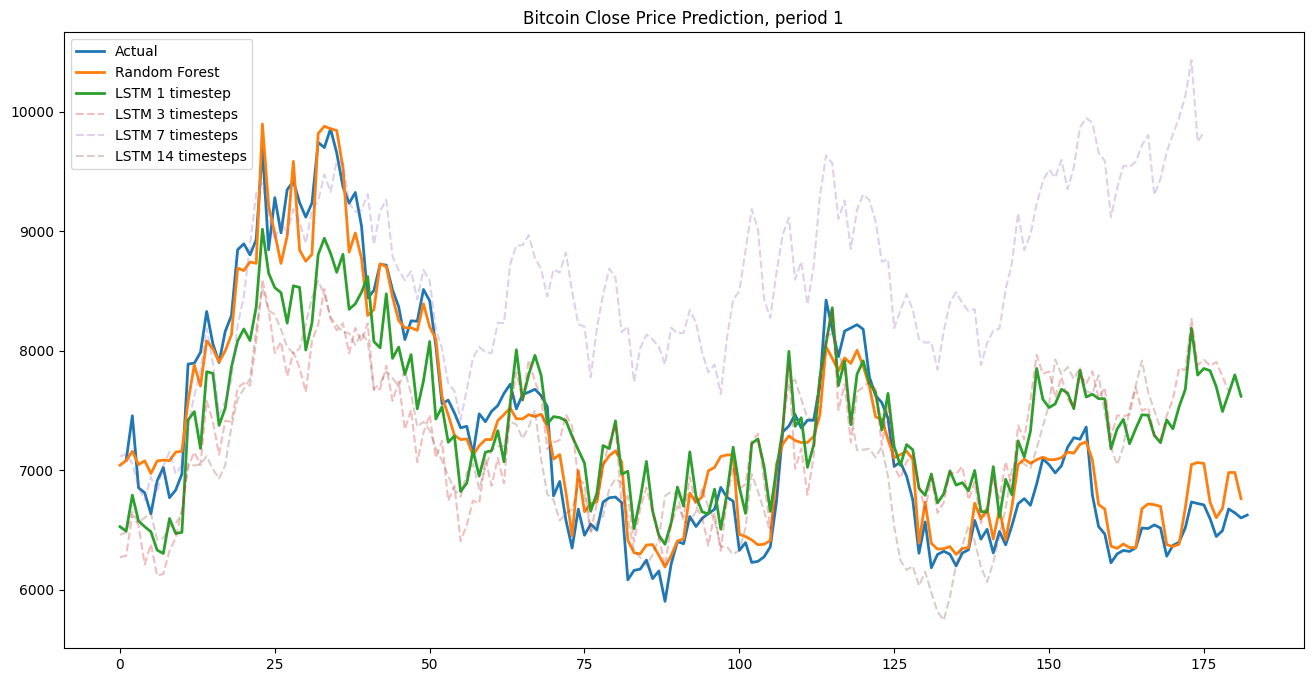

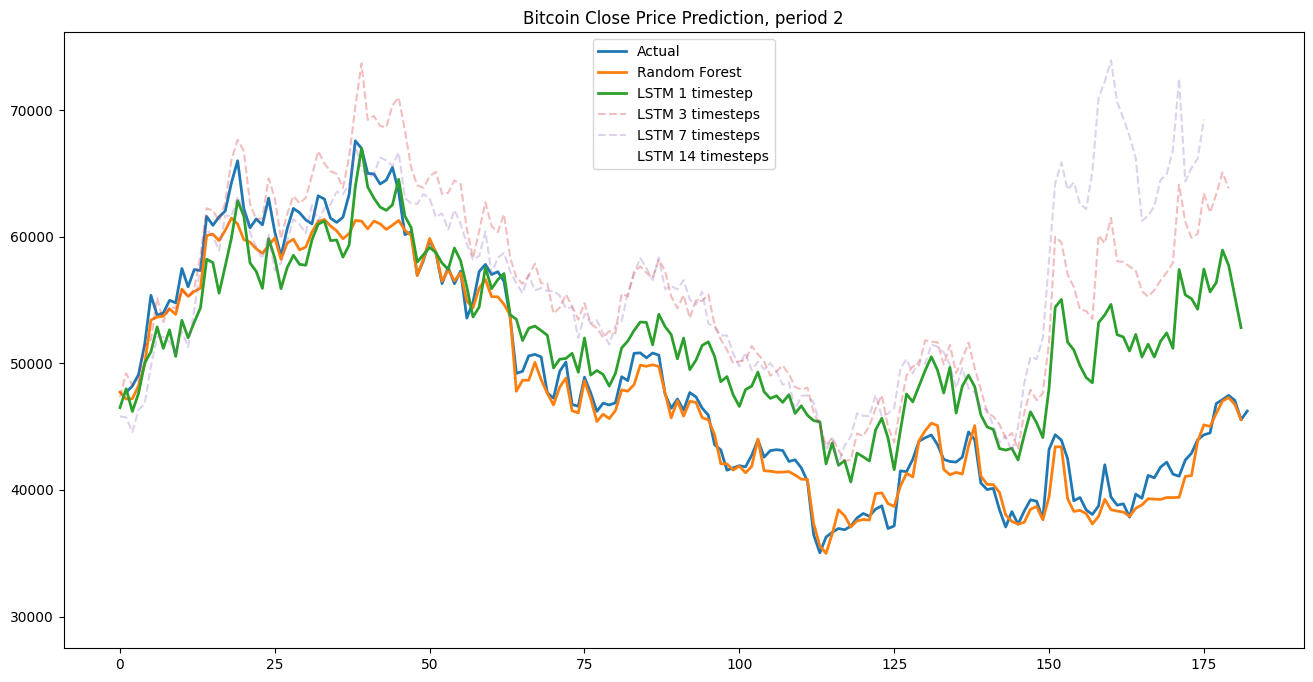

==================================================RMSE==================================================
RMSE RF p1:  318.4543898799673
RMSE LSTM 1 timestep p1:  663.373828121008
RMSE LSTM 3 timesteps p1:  846.325067463685
RMSE LSTM 7 timesteps p1:  1818.675822122748
RMSE LSTM 14 timesteps p1:  1085.487220903563
RMSE RF p2:  2147.891926510752
RMSE LSTM 1 timestep p2:  6268.234574074247
RMSE LSTM 3 timesteps p2:  9420.086891815397
RMSE LSTM 7 timesteps p2:  11761.866620909073
RMSE LSTM 14 timesteps p2:  12045.417888671462
==================================================MAPE==================================================
MAPE RF p1:  0.03287521901218729
MAPE LSTM 1 timestep p1:  0.07754347172704679
MAPE LSTM 3 timesteps p1:  0.09695281263005977
MAPE LSTM 7 timesteps p1:  0.22976983972253845
MAPE LSTM 14 timesteps p1:  0.11618919872590774
MAPE RF p2:  0.033872827919756786
MAPE LSTM 1 timestep p2:  0.11637537593775267
MAPE LSTM 3 timesteps p2:  0.17905130912375103
MAPE LSTM 7 timestep

In [ ]:
# Plot
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Close Price Prediction, period 1')
plt.plot(Y_test_RF_p1, label='Actual', linewidth=2)
plt.plot(RF_p1_results[0], label='Random Forest', linewidth=2)
plt.plot(LSTM_l1_p1_results[0], label='LSTM 1 timestep', linewidth=2)
plt.plot(LSTM_l3_p1_results[0], label='LSTM 3 timesteps', alpha=0.3, linestyle = '--')
plt.plot(LSTM_l7_p1_results[0], label='LSTM 7 timesteps', alpha=0.3, linestyle = '--')
plt.plot(LSTM_l14_p1_results[0], label='LSTM 14 timesteps', alpha=0.3, linestyle = '--')
plt.legend()
plt.show()

plt.figure(figsize=(16, 8))
plt.title('Bitcoin Close Price Prediction, period 2')
plt.plot(Y_test_RF_p2, label='Actual', linewidth=2)
plt.plot(RF_p2_results[0], label='Random Forest', linewidth=2)
plt.plot(LSTM_l1_p2_results[0], label='LSTM 1 timestep', linewidth=2)
plt.plot(LSTM_l3_p2_results[0], label='LSTM 3 timesteps', alpha=0.3, linestyle = '--')
plt.plot(LSTM_l7_p2_results[0], label='LSTM 7 timesteps', alpha=0.3, linestyle = '--')
plt.plot(LSTM_l14_p2_results[0], label='LSTM 14 timesteps', alpha=0., linestyle = '--')
plt.legend()
plt.show()


# RMSE
print("="*50 + "RMSE" + "="*50)
print("RMSE RF p1: ", root_mean_squared_error(Y_test_RF_p1, RF_p1_results[0]))
print("RMSE LSTM 1 timestep p1: ", root_mean_squared_error(Y_test_LSTM_l1_p1, LSTM_l1_p1_results[0]))
print("RMSE LSTM 3 timesteps p1: ", root_mean_squared_error(Y_test_LSTM_l3_p1, LSTM_l3_p1_results[0]))
print("RMSE LSTM 7 timesteps p1: ", root_mean_squared_error(Y_test_LSTM_l7_p1, LSTM_l7_p1_results[0]))
print("RMSE LSTM 14 timesteps p1: ", root_mean_squared_error(Y_test_LSTM_l14_p1, LSTM_l14_p1_results[0]))

print("RMSE RF p2: ", root_mean_squared_error(Y_test_RF_p2, RF_p2_results[0]))
print("RMSE LSTM 1 timestep p2: ", root_mean_squared_error(Y_test_LSTM_l1_p2, LSTM_l1_p2_results[0]))
print("RMSE LSTM 3 timesteps p2: ", root_mean_squared_error(Y_test_LSTM_l3_p2, LSTM_l3_p2_results[0]))
print("RMSE LSTM 7 timesteps p2: ", root_mean_squared_error(Y_test_LSTM_l7_p2, LSTM_l7_p2_results[0]))
print("RMSE LSTM 14 timesteps p2: ", root_mean_squared_error(Y_test_LSTM_l14_p2, LSTM_l14_p2_results[0]))

# MAPE
print("="*50 + "MAPE" + "="*50)
print("MAPE RF p1: ", mean_absolute_percentage_error(Y_test_RF_p1, RF_p1_results[0]))
print("MAPE LSTM 1 timestep p1: ", mean_absolute_percentage_error(Y_test_LSTM_l1_p1, LSTM_l1_p1_results[0]))
print("MAPE LSTM 3 timesteps p1: ", mean_absolute_percentage_error(Y_test_LSTM_l3_p1, LSTM_l3_p1_results[0]))
print("MAPE LSTM 7 timesteps p1: ", mean_absolute_percentage_error(Y_test_LSTM_l7_p1, LSTM_l7_p1_results[0]))
print("MAPE LSTM 14 timesteps p1: ", mean_absolute_percentage_error(Y_test_LSTM_l14_p1, LSTM_l14_p1_results[0]))

print("MAPE RF p2: ", mean_absolute_percentage_error(Y_test_RF_p2, RF_p2_results[0]))
print("MAPE LSTM 1 timestep p2: ", mean_absolute_percentage_error(Y_test_LSTM_l1_p2, LSTM_l1_p2_results[0]))
print("MAPE LSTM 3 timesteps p2: ", mean_absolute_percentage_error(Y_test_LSTM_l3_p2, LSTM_l3_p2_results[0]))
print("MAPE LSTM 7 timesteps p2: ", mean_absolute_percentage_error(Y_test_LSTM_l7_p2, LSTM_l7_p2_results[0]))
print("MAPE LSTM 14 timesteps p2: ", mean_absolute_percentage_error(Y_test_LSTM_l14_p2, LSTM_l14_p2_results[0]))


# DA
print("="*50 + "DA" + "="*50)
print("DA RF p1: ", directional_accuracy(Y_test_RF_p1, RF_p1_results[0]))
print("DA LSTM 1 timestep p1: ", directional_accuracy(Y_test_LSTM_l1_p1, LSTM_l1_p1_results[0]))
print("DA LSTM 3 timesteps p1: ", directional_accuracy(Y_test_LSTM_l3_p1, LSTM_l3_p1_results[0]))
print("DA LSTM 7 timesteps p1: ", directional_accuracy(Y_test_LSTM_l7_p1, LSTM_l7_p1_results[0]))
print("DA LSTM 14 timesteps p1: ", directional_accuracy(Y_test_LSTM_l14_p1, LSTM_l14_p1_results[0]))

print("DA RF p2: ", directional_accuracy(Y_test_RF_p2, RF_p2_results[0]))
print("DA LSTM 1 timestep p2: ", directional_accuracy(Y_test_LSTM_l1_p2, LSTM_l1_p2_results[0]))
print("DA LSTM 3 timesteps p2: ", directional_accuracy(Y_test_LSTM_l3_p2, LSTM_l3_p2_results[0]))
print("DA LSTM 7 timesteps p2: ", directional_accuracy(Y_test_LSTM_l7_p2, LSTM_l7_p2_results[0]))
print("DA LSTM 14 timesteps p2: ", directional_accuracy(Y_test_LSTM_l14_p2, LSTM_l14_p2_results[0]))


2026/01/08 03:26:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/coder/miniconda3/envs/mlflow-fd36bac35c4ea7229080774d8c3871a103b15657/lib/python3.9/site-packages/boto3/compat.py:89: PythonDeprecationWarning: Boto3 will no longer support Python 3.9 starting April 29, 2026. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.10 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/"


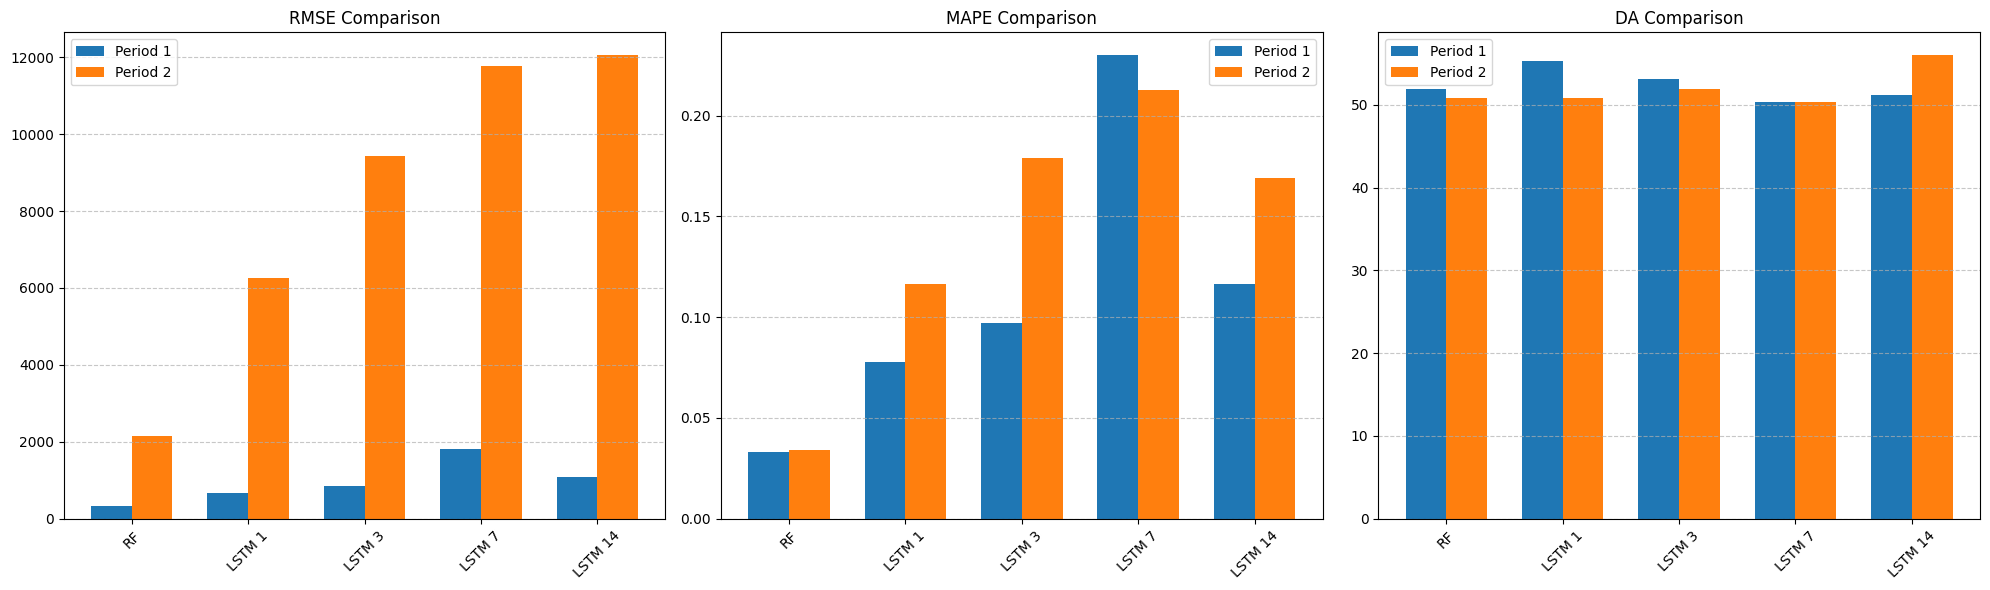

In [ ]:
# Create DataFrame for Metrics
metrics_data = {
    'Period': [],
    'Model': [],
    'RMSE': [],
    'MAPE': [],
    'DA': []
}

def append_metrics(period, model_label, y_true, y_pred):
    # Flatten if necessary (for LSTM outputs which are (N, 1))
    if hasattr(y_pred, 'shape') and len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
        y_pred = y_pred.flatten()
    elif isinstance(y_pred, list):
         y_pred = np.array(y_pred)

    y_true = np.array(y_true)
    
    # Calculate metrics
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    da = directional_accuracy(y_true, y_pred)
    
    metrics_data['Period'].append(period)
    metrics_data['Model'].append(model_label)
    metrics_data['RMSE'].append(rmse)
    metrics_data['MAPE'].append(mape)
    metrics_data['DA'].append(da)

# Period 1
append_metrics('Period 1', 'RF', Y_test_RF_p1, RF_p1_results[0])
append_metrics('Period 1', 'LSTM 1', Y_test_LSTM_l1_p1, LSTM_l1_p1_results[0])
append_metrics('Period 1', 'LSTM 3', Y_test_LSTM_l3_p1, LSTM_l3_p1_results[0])
append_metrics('Period 1', 'LSTM 7', Y_test_LSTM_l7_p1, LSTM_l7_p1_results[0])
append_metrics('Period 1', 'LSTM 14', Y_test_LSTM_l14_p1, LSTM_l14_p1_results[0])

# Period 2
append_metrics('Period 2', 'RF', Y_test_RF_p2, RF_p2_results[0])
append_metrics('Period 2', 'LSTM 1', Y_test_LSTM_l1_p2, LSTM_l1_p2_results[0])
append_metrics('Period 2', 'LSTM 3', Y_test_LSTM_l3_p2, LSTM_l3_p2_results[0])
append_metrics('Period 2', 'LSTM 7', Y_test_LSTM_l7_p2, LSTM_l7_p2_results[0])
append_metrics('Period 2', 'LSTM 14', Y_test_LSTM_l14_p2, LSTM_l14_p2_results[0])

df_metrics = pd.DataFrame(metrics_data)

# Plotting using Matplotlib only
metrics_list = ['RMSE', 'MAPE', 'DA']
models = df_metrics['Model'].unique()
x = np.arange(len(models))
width = 0.35

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, metric in enumerate(metrics_list):
    ax = axes[i]
    
    # Retrieve data for each period preserving model order
    p1_data = []
    p2_data = []
    for model in models:
        val1 = df_metrics[(df_metrics['Period'] == 'Period 1') & (df_metrics['Model'] == model)][metric].values[0]
        val2 = df_metrics[(df_metrics['Period'] == 'Period 2') & (df_metrics['Model'] == model)][metric].values[0]
        p1_data.append(val1)
        p2_data.append(val2)
    
    rects1 = ax.bar(x - width/2, p1_data, width, label='Period 1')
    rects2 = ax.bar(x + width/2, p2_data, width, label='Period 2')
    
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

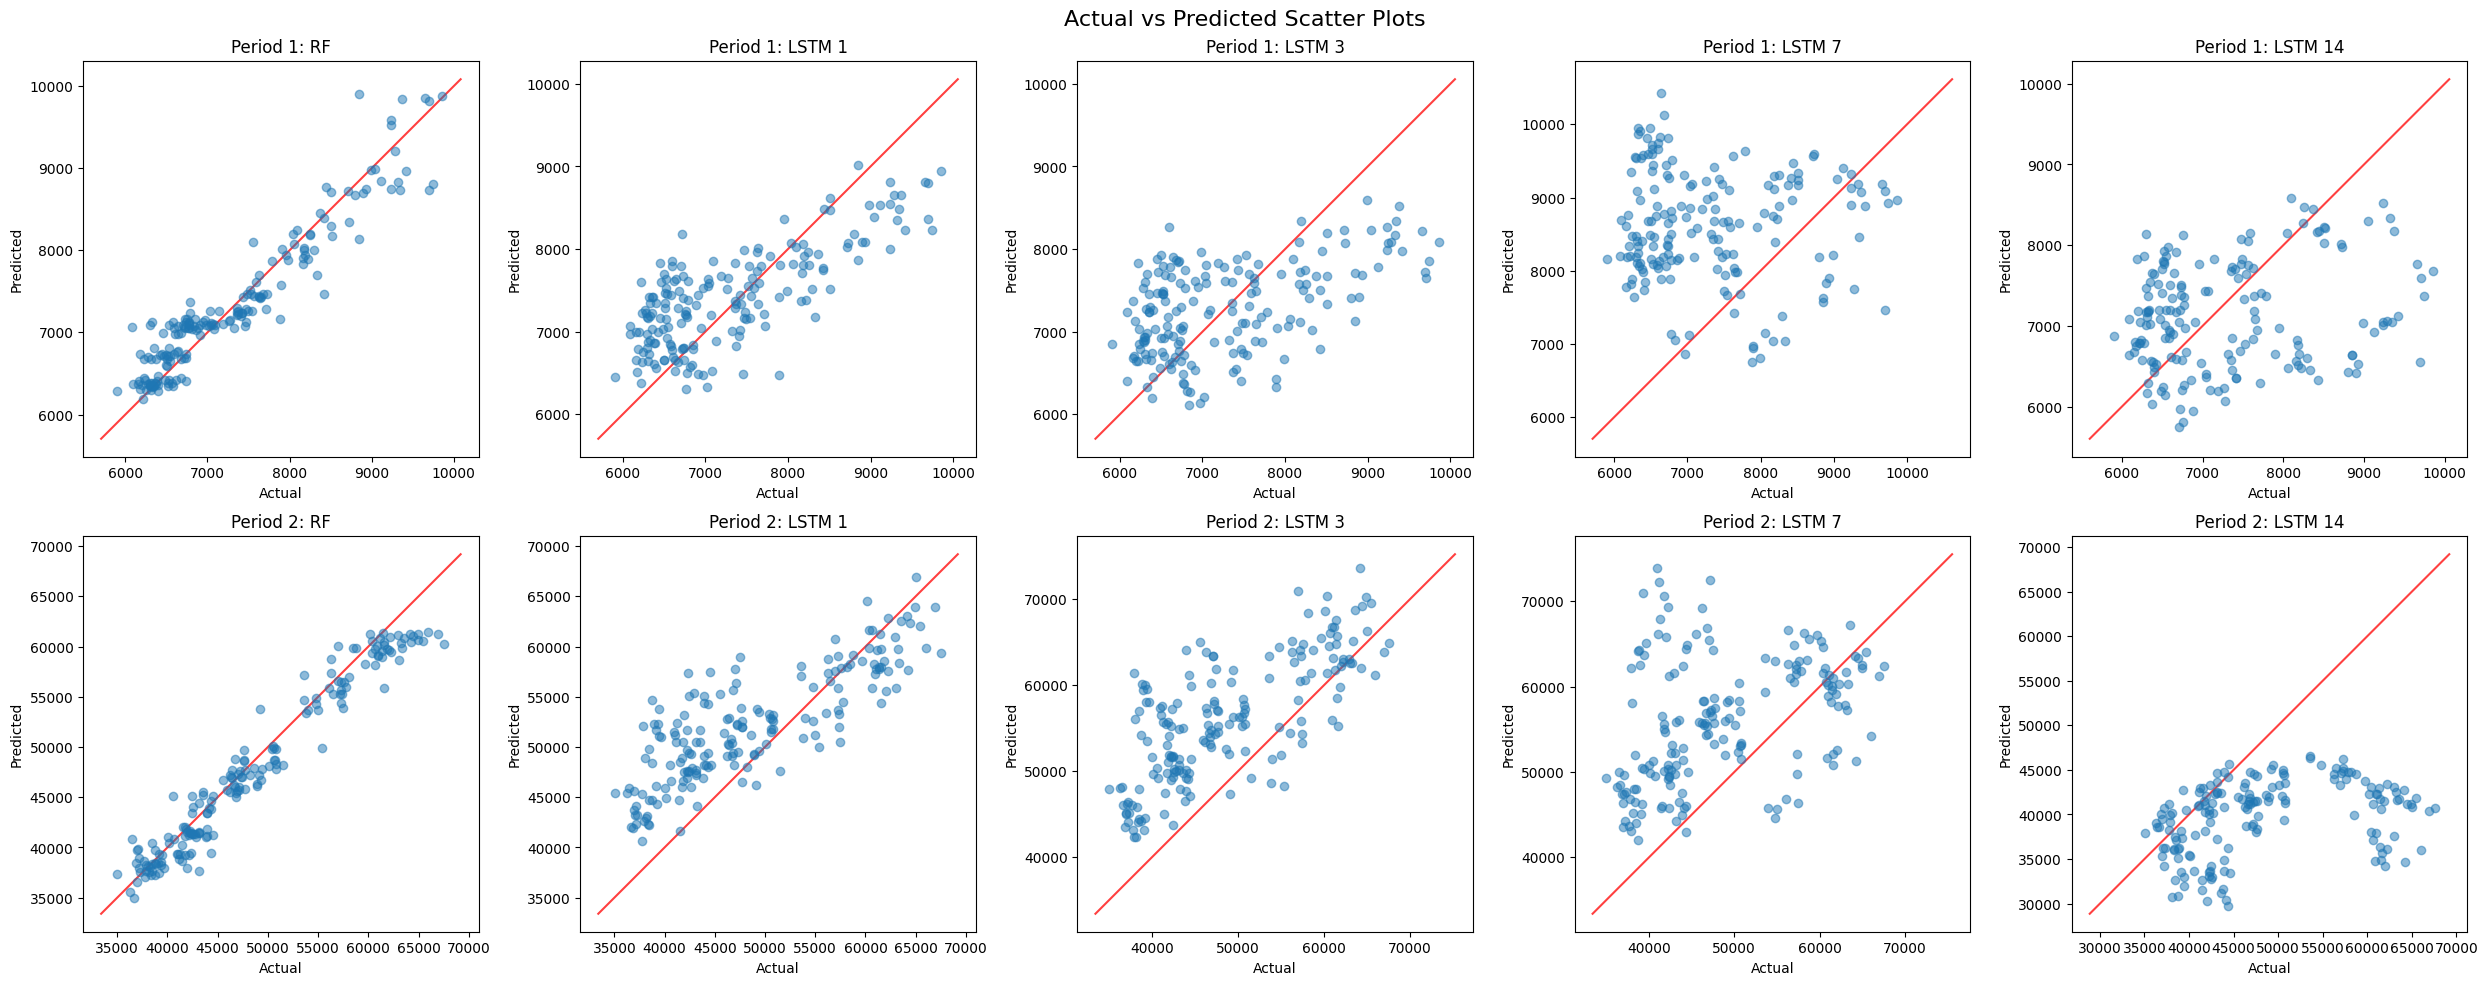

In [ ]:
# 1. Scatter Plots: Actual vs Predicted
def plot_scatter(y_true, y_pred, title, ax):
    # Flatten if necessary
    if hasattr(y_pred, 'shape') and len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
        y_pred = y_pred.flatten()
    elif isinstance(y_pred, list):
         y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    ax.scatter(y_true, y_pred, alpha=0.5)
    
    # Plot diagonal line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Actual vs Predicted Scatter Plots', fontsize=16)

# Prepare data pairs for Period 1
models_p1 = [
    ('RF', Y_test_RF_p1, RF_p1_results[0]),
    ('LSTM 1', Y_test_LSTM_l1_p1, LSTM_l1_p1_results[0]),
    ('LSTM 3', Y_test_LSTM_l3_p1, LSTM_l3_p1_results[0]),
    ('LSTM 7', Y_test_LSTM_l7_p1, LSTM_l7_p1_results[0]),
    ('LSTM 14', Y_test_LSTM_l14_p1, LSTM_l14_p1_results[0])
]

# Prepare data pairs for Period 2
models_p2 = [
    ('RF', Y_test_RF_p2, RF_p2_results[0]),
    ('LSTM 1', Y_test_LSTM_l1_p2, LSTM_l1_p2_results[0]),
    ('LSTM 3', Y_test_LSTM_l3_p2, LSTM_l3_p2_results[0]),
    ('LSTM 7', Y_test_LSTM_l7_p2, LSTM_l7_p2_results[0]),
    ('LSTM 14', Y_test_LSTM_l14_p2, LSTM_l14_p2_results[0])
]

# Plot Period 1
for i, (name, y_true, y_pred) in enumerate(models_p1):
    plot_scatter(y_true, y_pred, f'Period 1: {name}', axes[0, i])

# Plot Period 2
for i, (name, y_true, y_pred) in enumerate(models_p2):
    plot_scatter(y_true, y_pred, f'Period 2: {name}', axes[1, i])

plt.tight_layout()
plt.show()

/tmp/ipykernel_6612/1381884092.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(data_box_p1, labels=labels_p1)
/tmp/ipykernel_6612/1381884092.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_box_p2, labels=labels_p2)


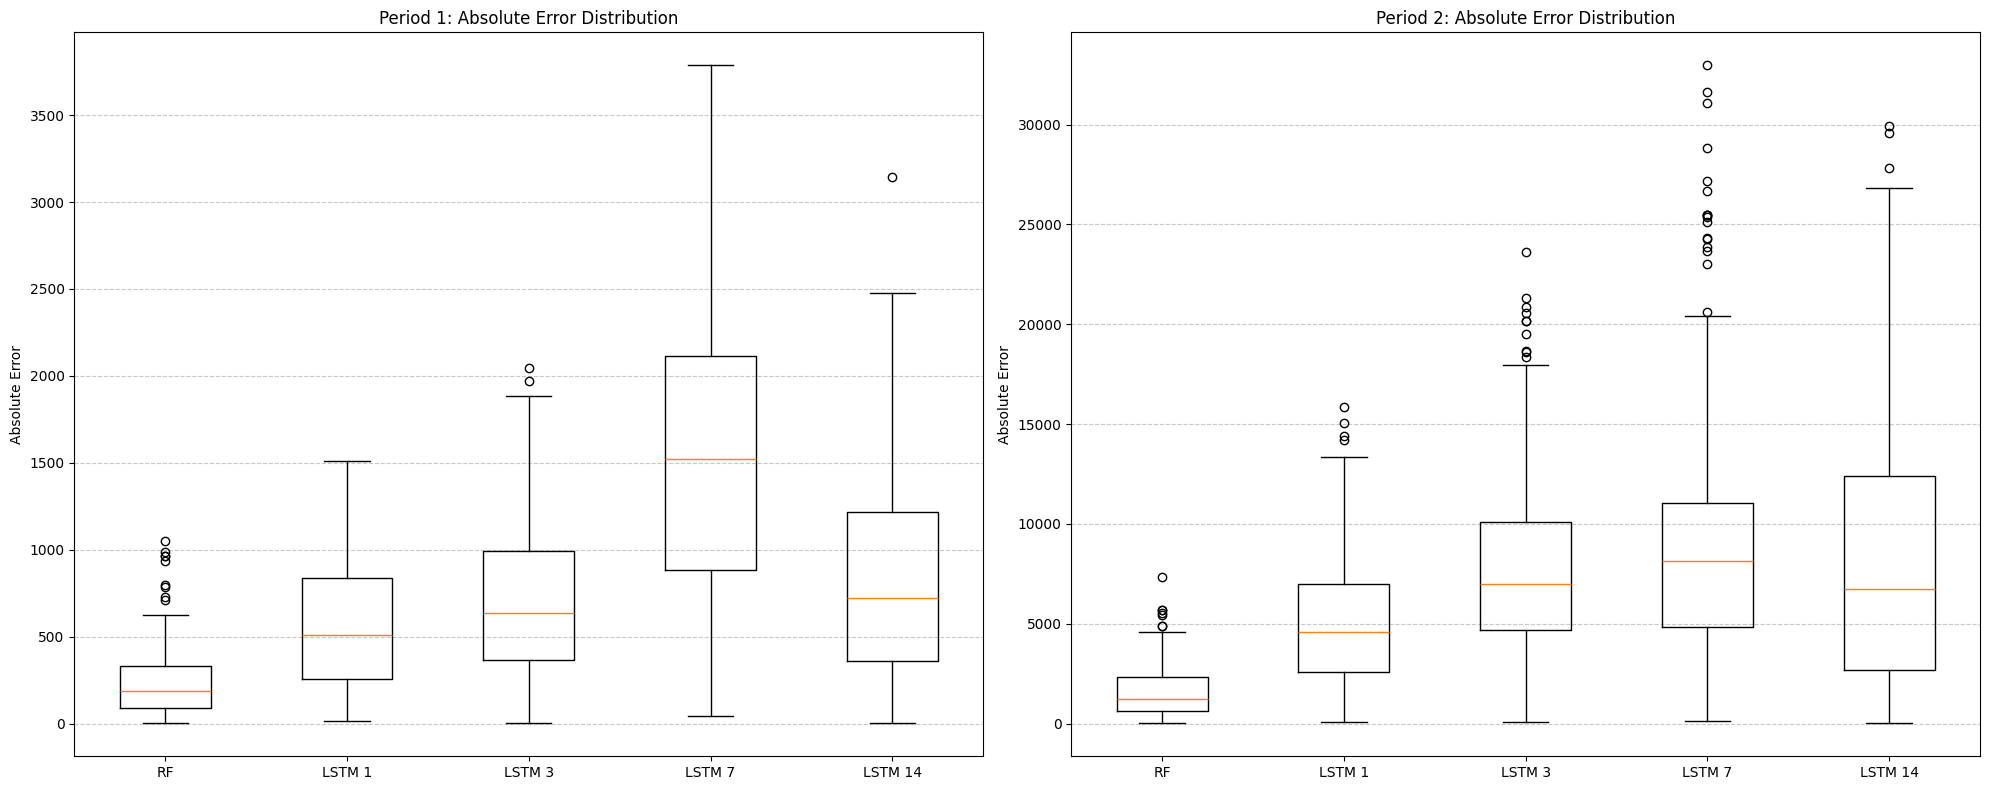

In [ ]:
# 2. Box Plots of Absolute Errors
def get_abs_errors(y_true, y_pred):
    if hasattr(y_pred, 'shape') and len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
        y_pred = y_pred.flatten()
    elif isinstance(y_pred, list):
         y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.abs(y_true - y_pred)

data_box_p1 = []
labels_p1 = []
for name, y_true, y_pred in models_p1:
    data_box_p1.append(get_abs_errors(y_true, y_pred))
    labels_p1.append(name)

data_box_p2 = []
labels_p2 = []
for name, y_true, y_pred in models_p2:
    data_box_p2.append(get_abs_errors(y_true, y_pred))
    labels_p2.append(name)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Period 1
axes[0].boxplot(data_box_p1, labels=labels_p1)
axes[0].set_title('Period 1: Absolute Error Distribution')
axes[0].set_ylabel('Absolute Error')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Period 2
axes[1].boxplot(data_box_p2, labels=labels_p2)
axes[1].set_title('Period 2: Absolute Error Distribution')
axes[1].set_ylabel('Absolute Error')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()